# Data Analysis Immo_Rent

This data analysis intends to be completely independant of magic numbers and variable names. For this reason, the columns of the data set must be in the right order: immoId, objType, cityName, zipCode, regionId, canton, street, rooms, floor, surface, yearBuilt, yearRenovated, lon, lat, distanceToStation, netPrice, extraPrice, price

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sys
import os
import math

df = pd.read_csv('..\\data_file\\object_file - modified_v2.csv')

#removes the semicolon of the last attributes if exists
def remove_semicolon(row):
    return row[df.columns[df.shape[1]-1]].replace(';', '')
if df.columns[df.shape[1]-1][-1] == ';': 
    df.rename(columns = {df.columns[df.shape[1]-1] : df.columns[df.shape[1]-1][:len(df.columns[df.shape[1]-1])-1]}, inplace = True)
    df[df.columns[df.shape[1]-1]] = df.apply(lambda row: remove_semicolon(row), axis=1)


df_size = df.shape[0]
percentage = '{:.1%}'
count = 'count'
float_regex = '\d+(\.)?(\d)*'
na = '<NA>'



## Missing Values

### Missing Values Dependency

First we have to get an imagination of where and why I have missing values. In addition, I want to know if the density of missing values has any connection to other missing values.

In order to get an overview of these missing values, I created a heatmap of how many data objects are missing both kind of each attribute in the data-set.

The first heatmap shows the absolute number of objects which miss both compared attributes. The second heatmap contains the same data set as the first map, but with logarithmic values based on 10, so that data objects with a lower frequency of missing attribute pairs can also be displayed appropriately.

In [2]:
def create_missing_values_table(frame, missing = na):
    """creates a full table of each row and column of the dataframe and checks, how many missing values are in the comparison"""
    missing_values_table = pd.DataFrame(0, index = frame.columns, columns = frame.columns)
    for column in frame.columns:
        for row in frame.columns:
            sub_frame = frame[[column, row]]
            try: #compares if both: columns with the values of 'column' and 'row' have missing values, even compared with itself
                num_missing = sub_frame[(sub_frame.loc[:, column] == missing) & 
                                        (sub_frame.loc[:, row] == missing)].iloc[:,0].value_counts()[missing]
            except KeyError: #if there is a KeyError, that means that no missing values are found
                num_missing = 0
            missing_values_table.loc[column, row] = num_missing
    return missing_values_table


missing_values_table = create_missing_values_table(df)
missing_values_table_2 = missing_values_table.copy()
missing_values_table_2 += 1
missing_values_table_2 = np.log10(missing_values_table_2)

C:\Users\Lukas\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


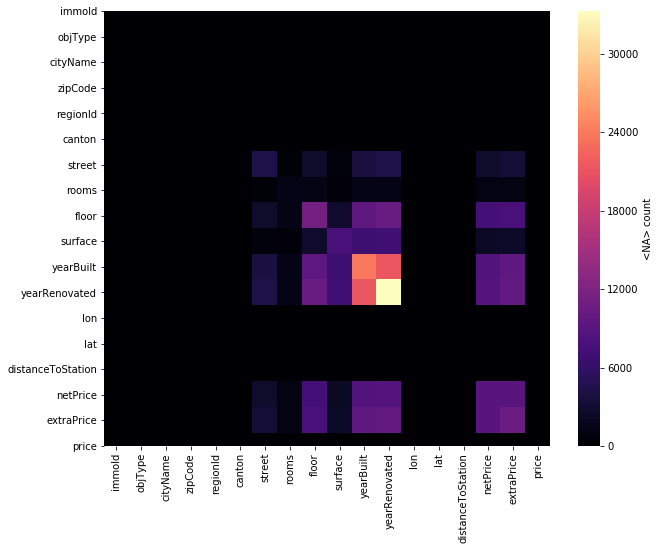

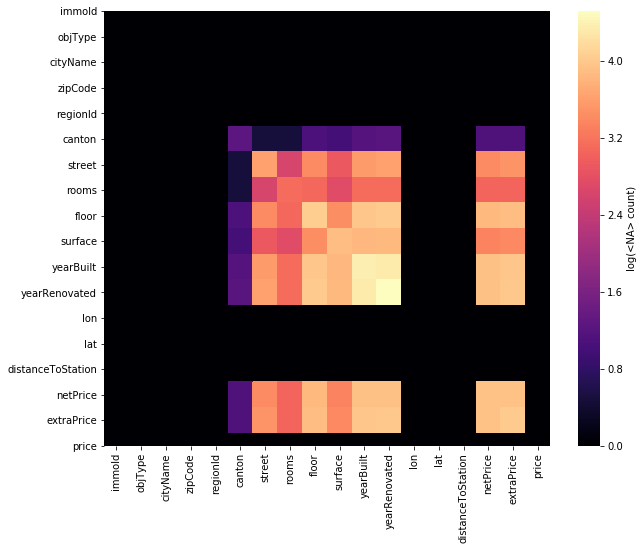

In [3]:
plt.figure(figsize=(10, 8))
sns.heatmap(missing_values_table, cmap="magma", cbar_kws={'label': (na+' '+count)})
plt.figure(figsize=(10, 8))
sns.heatmap(missing_values_table_2, cmap="magma", cbar_kws={'label': ('log('+na+' '+count+')')})

### Absolute and Relative Missing Values

In [4]:
rel = 'relative'

def count_missing(frame, missing = na):
    missing_count = pd.DataFrame(0, index = frame.columns, columns = [missing, rel])
    for column in frame.columns:
        sub_frame = frame.loc[:, column]
        try:
            count_missing = sub_frame.value_counts()[missing]
            missing_count.loc[column, missing] = count_missing
            missing_count.loc[column, rel] = percentage.format(count_missing / frame.shape[0])
        except KeyError:
            missing_count.loc[column, missing] = 0
            missing_count.loc[column, rel] = percentage.format(0)
    return missing_count

print(count_missing(df))

                    <NA> relative
immoId                 0     0.0%
objType                0     0.0%
cityName               0     0.0%
zipCode                0     0.0%
regionId               0     0.0%
canton                17     0.0%
street              4326    11.3%
rooms               1382     3.6%
floor              11139    29.2%
surface             7892    20.7%
yearBuilt          23855    62.5%
yearRenovated      33277    87.2%
lon                    0     0.0%
lat                    0     0.0%
distanceToStation      0     0.0%
netPrice            9020    23.6%
extraPrice         10428    27.3%
price                  0     0.0%


### Missing Values per Object Distribution / Data Transformation

In [5]:
def count_na_in_row(row, missing):
    row_count = 0
    if missing == na:
        for value in row:
            if value == missing:
                row_count += 1
    else:
        row_count = len(row) - row.count()
    return row_count

miss = 'missing_class'
miss_range = None
def create_missing_values_set(frame, missing = na): #about 10 sec
    if missing != na: #replace all NaN with <NA>
        frame = frame.replace(np.nan, na, regex = True)
        missing = na
    frame[miss] = frame.apply(lambda row: count_na_in_row(row, missing), axis=1) #creates missing_class (num_of_missing_values)
    df_missing_grouped = frame.groupby(miss)
    global miss_range
    miss_range = range(1, frame.loc[:, miss].max()+1)
    missing_set = pd.DataFrame(index = miss_range)
    for attribute in frame.columns:
        values = []
        for i in miss_range:
            try: #tries to get the counted grouped value missing of the specific attribute
                values.append(df_missing_grouped[attribute].value_counts()[i, missing])
            except KeyError:
                values.append(0)
        missing_set[attribute] = values
    return missing_set

missing_set = create_missing_values_set(df)
print(missing_set)

   immoId  objType  cityName  zipCode  regionId  canton  street  rooms  floor  \
1       0        0         0        0         0       0      13      7    173   
2       0        0         0        0         0       1     251     28   1182   
3       0        0         0        0         0       4     659     91   1258   
4       0        0         0        0         0       0     591     76   1108   
5       0        0         0        0         0       0     669     55   3682   
6       0        0         0        0         0       6    1292    475   2645   
7       0        0         0        0         0       4     638    437    878   
8       0        0         0        0         0       1     212    212    212   
9       0        0         0        0         0       1       1      1      1   

   surface  yearBuilt  yearRenovated  lon  lat  distanceToStation  netPrice  \
1       94       1239           9115    0    0                  0         0   
2     1115       7591          

### Missing Values Distribution of each Data Object

This plot describes how the missing values are distributed in data objects, where 1, 2, 3.. (missing_class) values are missing. The y-axis describes the relative density of the missing values per missing class. It does not provide any information about how many data objects in each missing_class are missing. If one is interested in this kind of information, take a look at the next plot. In my opinion, it was not appropriate to show this in the same plot because it is difficult to get an overview of the distribution of missing_classes with a relative low amound of data objects. 

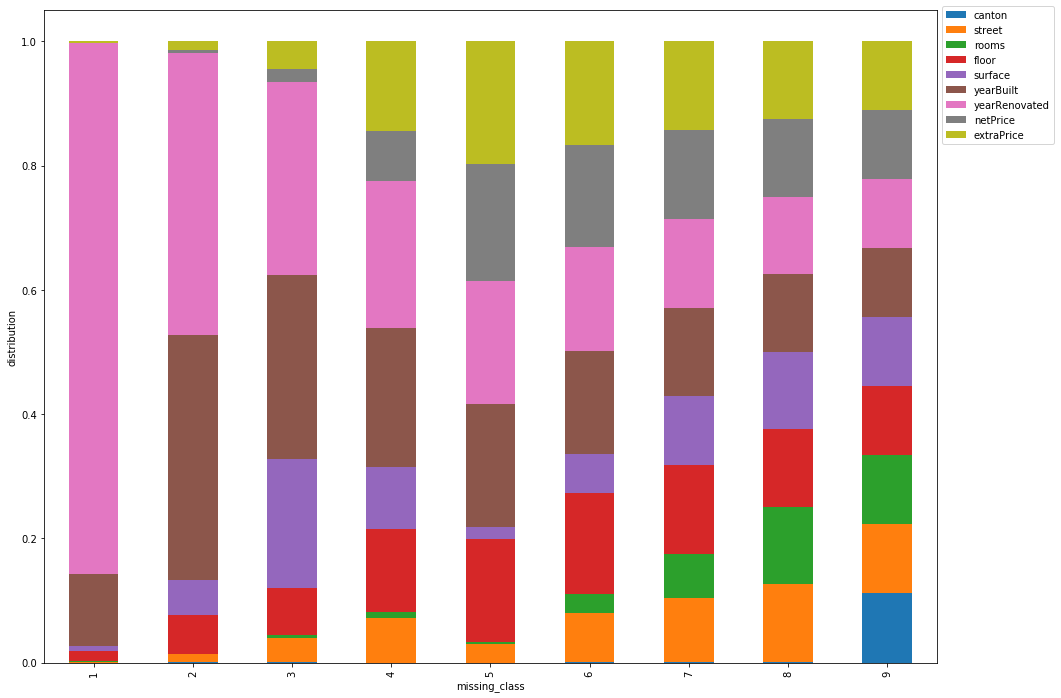

In [6]:
def missing_distribution_100(frame):
    frame = frame.copy()
    frame = frame.loc[:, (frame != 0).any(axis=0)] #drops all full zero columns
    frame_scaled_100 = frame.div(frame.sum(1), axis=0) #scale to 100%
    frame_scaled_100.plot(kind='bar', stacked=True, figsize=(16, 12), legend=False)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))
    plt.xlabel(miss)
    plt.ylabel('distribution')
    
missing_100 = missing_distribution_100(missing_set)
missing_100

Here one can see the distribution of the number of missing value objects.

objects with no missing values:  1915.0 



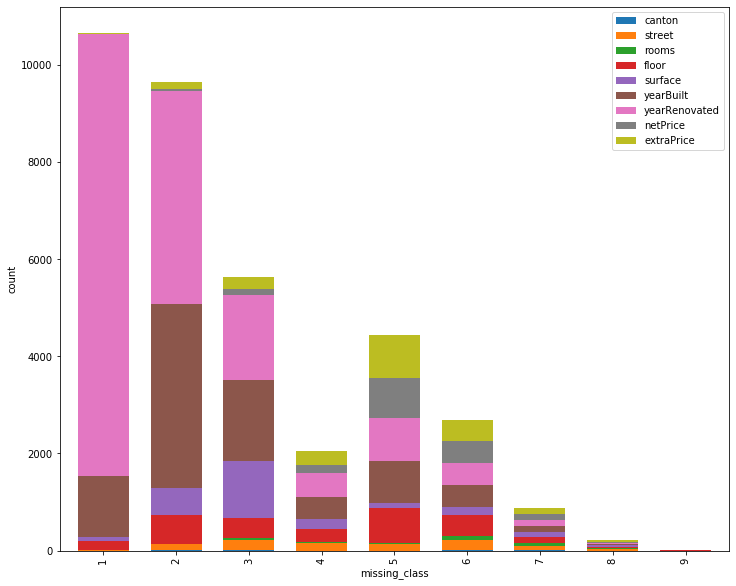

In [7]:
def missing_distribution(frame, original_frame_size):
    frame = frame.copy()
    frame = frame.loc[:, (frame != 0).any(axis=0)]
    number_of_objects_with_missing_values = 0
    for missing_class in miss_range: #adapt count values to count objects
        frame.loc[missing_class] = frame.loc[missing_class].div(missing_class)
        number_of_objects_with_missing_values += frame.loc[missing_class].sum(axis = 0)
        
    print('objects with no missing values: ', original_frame_size - number_of_objects_with_missing_values, os.linesep)
    frame.plot(kind='bar', figsize=(12, 10), width = 0.7, stacked = True)
    plt.xlabel(miss)
    plt.ylabel(count)
    
missing_dist = missing_distribution(missing_set, df_size)
missing_dist

## 1 Dimensonal Analysis

### Object Type

Here I am interested in the distribution of flats and houses, because my assumption is that this attribute can have an impact on the price estimation and when I have to drop some data objects, I intend not to lose too much of the relatively underpresented object type "house".

  objType  count relative
0    flat  36826    96.5%
1   house   1324     3.5%


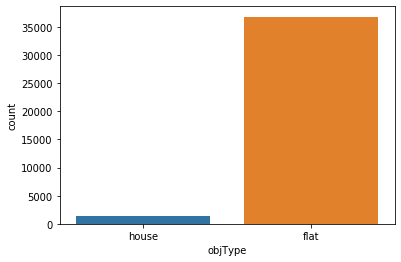

In [8]:
def object_distribution(frame):
    object_types = frame[frame.columns[1]].value_counts().rename_axis(frame.columns[1]).reset_index(name = count)
    relative = [percentage.format(object_types.loc[0, count] / frame.shape[0]),
                percentage.format(object_types.loc[1, count] / frame.shape[0])]
    object_types = object_types.assign(relative = relative)
    print(object_types)
    sns.countplot(x = frame.columns[1], data = frame)
    
object_distribution(df)

### City and Zip-Code

It is interesting that most of the zip-codes contain just a few rent objects. I think because of this it can be important to split the zip-codes since each number in the code contains certain geographic information to not let a single zip-code have too much weight in the model.

count    2417.000000
mean       15.784030
std        31.055942
min         1.000000
25%         2.000000
50%         6.000000
75%        15.000000
max       529.000000
Name: count, dtype: float64

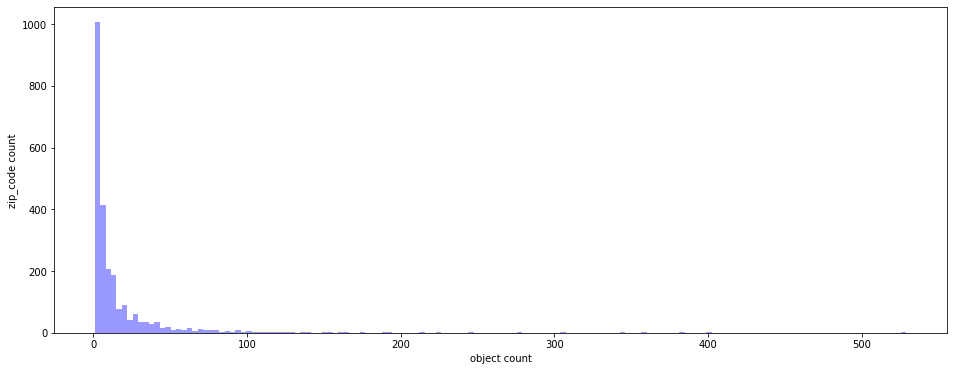

In [9]:
def zip_distribution(frame):
    plz_count = frame.zipCode.value_counts().rename_axis(frame.columns[3]).reset_index(name = count)
    plt.figure(figsize=(16, 6))
    ax = sns.distplot(plz_count[count], bins = 150, norm_hist = False, kde = False, color = 'blue')
    ax.set(xlabel='object '+count, ylabel='zip_code '+count)
    return plz_count.loc[:, count].describe()
    
zip_distribution(df)

### Canton

This plot shows the distribution of the number of rent objects in each canton. The canton is an additional geographical feature which could have an impact on the rental price. 

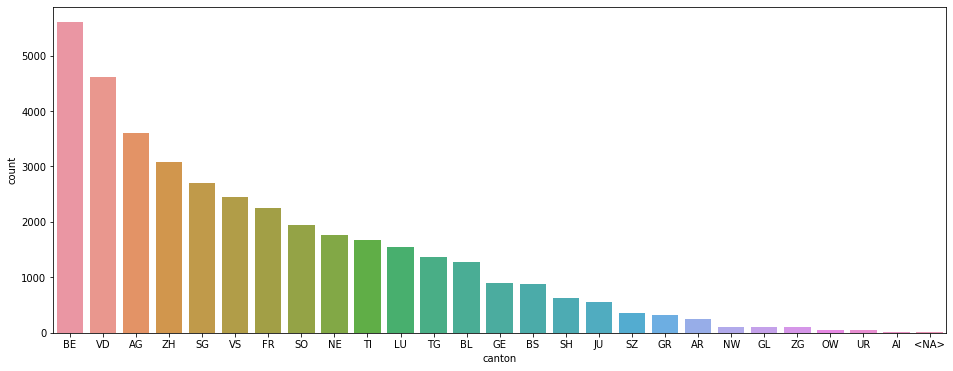

In [10]:
def canton_distribution(frame):
    plt.figure(figsize=(16, 6))
    sns.countplot(x = frame.columns[5], data = frame, order = frame[frame.columns[5]].value_counts().index)
    
canton_distribution(df)

### Rooms

This analysis shows the distribution of the rooms of the rental objects. Outliers can be identified here in particular. It is very unlikely that a rental object with 235 rooms exists, and I have never heard of an object with 3.4 rooms, so I will drop both data objects.

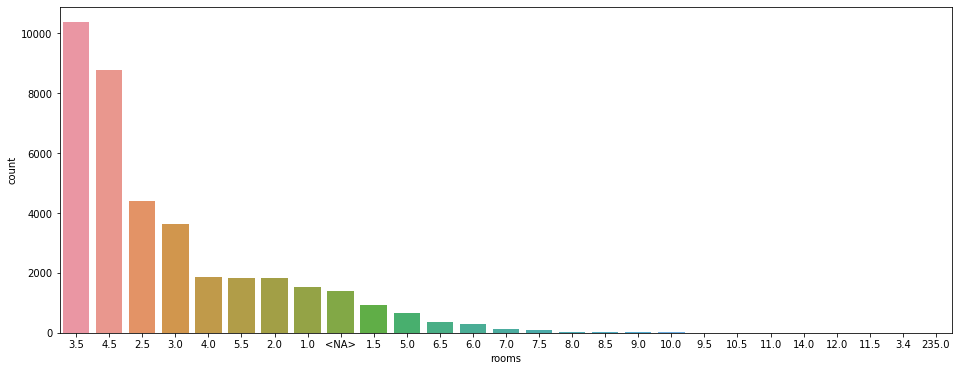

In [11]:
def rooms_distribution(frame):
    plt.figure(figsize=(16, 6))
    frame_rooms = frame.loc[:, frame.columns[7]].value_counts().rename_axis(frame.columns[7]).reset_index(name = count)
    sns.countplot(x = frame.columns[7], data = frame, order = frame[frame.columns[7]].value_counts().index)
    
rooms_distribution(df)

### Floor

The distribution of the floors show that most of the the rental objects are set in the range 0 to 5. There is an impossible floor number of 997, which I have to eliminate if I intend to use the floor in the model. Maybe it makes sense to divide the rental objects into 2-3 classes, because I have 1. many missing values, 2. floor 0 and 1 are sometimes interpreted as the same and 3. I don't have many objects with high floor numbers.

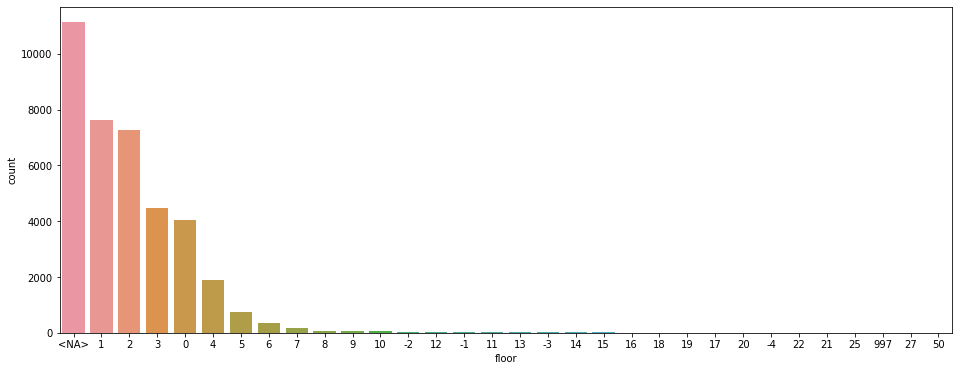

In [12]:
def floor_distribution(frame):
    plt.figure(figsize=(16, 6))
    frame_floors = frame.loc[:, frame.columns[8]].value_counts().rename_axis(frame.columns[8]).reset_index(name = count)
    sns.countplot(x = frame.columns[8], data = frame, order = frame[frame.columns[8]].value_counts().index)
    
floor_distribution(df)

### Surface

Obviously, the living space of a rented property plays an important role.

top 5:  
 0    682282
1      1500
2      1086
3       982
4       800
5       715
Name: surface, dtype: int64


count     30258.000000
mean        113.842851
std        3922.016393
min           1.000000
25%          68.000000
50%          86.000000
75%         109.000000
max      682282.000000
Name: surface, dtype: float64

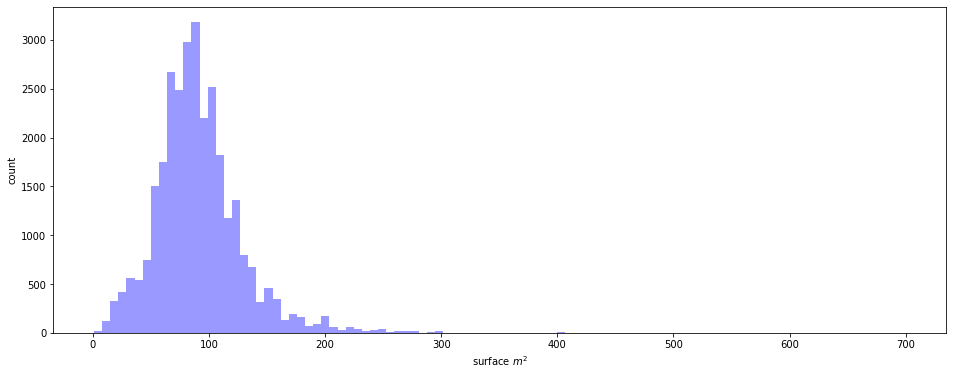

In [13]:
def surface_distribution(frame):
    frame_surface = frame.loc[:, frame.columns[9]]
    frame_surface = pd.to_numeric(frame_surface[frame_surface != na])
    frame_surface = frame_surface.sort_values(ascending = False).reset_index().loc[:, frame.columns[9]]
    plt.figure(figsize = (16, 6))
    print('top 5: ', os.linesep, frame_surface[:6])
    #in order to get an appropriate plot, some (e.g. first 5) extreme values must be dropped
    ax = sns.distplot(frame_surface[6:], bins = 100, norm_hist = False, kde = False, color = 'blue')
    ax.set(xlabel = 'surface $m^2$', ylabel = count)
    return frame_surface.describe()

surface_distribution(df)

### Year Built and Renovated

I am interested in how the age (building year) and renovation year of the buildings is distributed. It is important to note that a lot of data objects miss this attribute. Hence, this distribution is not representative, but still important in my opinion.

oldest 5:  
 0    1200
1    1292
2    1306
3    1365
4    1405
Name: yearBuilt, dtype: int64 

count    14295.000000
mean      1989.423575
std         40.016042
min       1200.000000
25%       1972.000000
50%       2001.000000
75%       2015.000000
max       2021.000000
Name: yearBuilt, dtype: float64 



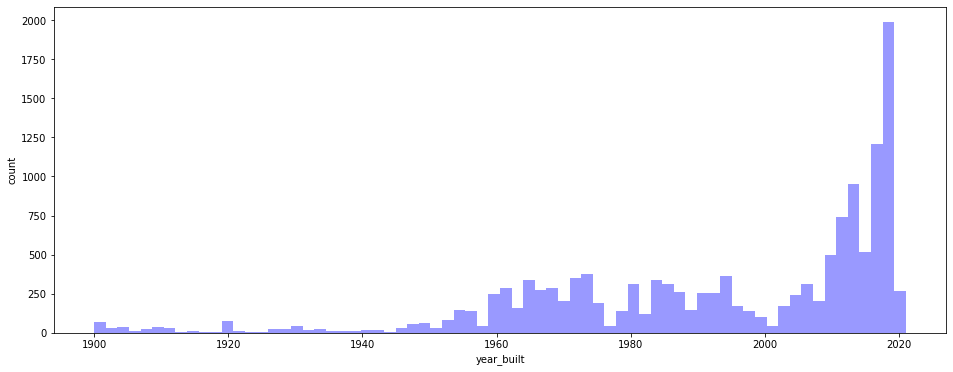

In [14]:
def year_distribution(frame, skip, bins, renovated = False):
    """plots the year_build or year_renovated dependent of the setting of 'renovated'
    skip is a relative skip in % to get a better overview of newer years , e.g. 1 is skip first 1% """
    index = 10 #index of yearBuilt
    axis_label = 'year_built'
    if renovated:
        index = 11 #index of yearRenovated
        axis_label = 'year_renovated'
    frame_year = frame.loc[:, frame.columns[index]]
    frame_year = pd.to_numeric(frame_year[frame_year != na])
    skip = int((skip / 100) * frame_year.shape[0]) #set skip absolute index
    frame_year = frame_year.sort_values(ascending = True).reset_index().loc[:, frame.columns[index]]
    plt.figure(figsize = (16, 6))
    print('oldest 5: ', os.linesep, frame_year[:5], os.linesep)
    ax = sns.distplot(frame_year[skip:], norm_hist = False, bins = bins, kde = False, color = 'blue')
    ax.set(xlabel = axis_label, ylabel = count)
    return frame_year.describe()
    
built = year_distribution(df, skip = 2, bins = 70)
print(built, os.linesep)

oldest 5:  
 0    1918
1    1954
2    1954
3    1954
4    1964
Name: yearRenovated, dtype: int64 

count    4873.000000
mean     2013.971681
std         6.746192
min      1918.000000
25%      2012.000000
50%      2016.000000
75%      2019.000000
max      2022.000000
Name: yearRenovated, dtype: float64 



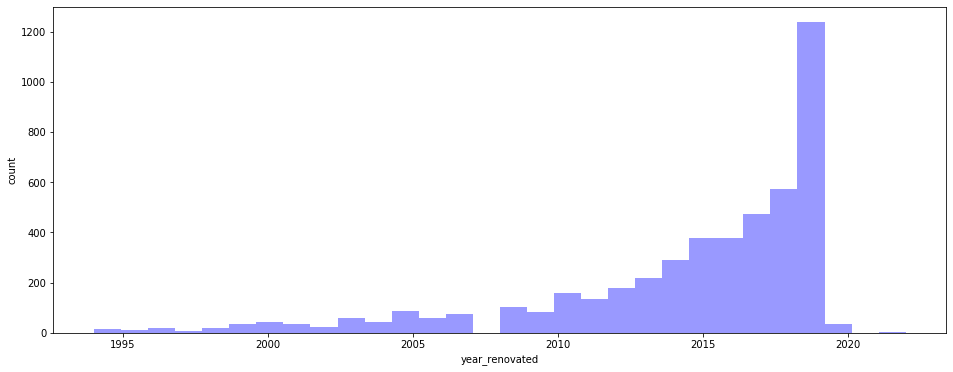

In [15]:
renovated = year_distribution(df, skip = 2, bins = 30, renovated = True)
print(renovated, os.linesep)

In [16]:
def get_number_renovated_but_no_built(frame):
    df_year_built_renovated = df.loc[:, [frame.columns[10], frame.columns[11]]]
    df_year_renovated_but_no_year_built = df_year_built_renovated[(df_year_built_renovated[frame.columns[11]] != na)
                                                                  & (df_year_built_renovated[frame.columns[10]] == na)]
    return df_year_renovated_but_no_year_built.shape[0]

print('number of data objects with a year_renovated, but no year_built value: ', get_number_renovated_but_no_built(df))

number of data objects with a year_renovated, but no year_built value:  2408


### Distance to Trainstation

Here I analyze the distance to the next train station in switzerland. This attribute is a computed distance value in km from the lat and lon (WGS 84) of the object to the lat and lon of the nearest train station.

Unfortunately not all lat and lon fetched were correct. They need to be corrected in a fruther step.

46  objects are out of specified range


count    38150.000000
mean         2.604621
std         46.660603
min          0.010781
25%          0.738215
50%          1.762487
75%          3.357045
max       8973.059153
Name: distanceToStation, dtype: float64

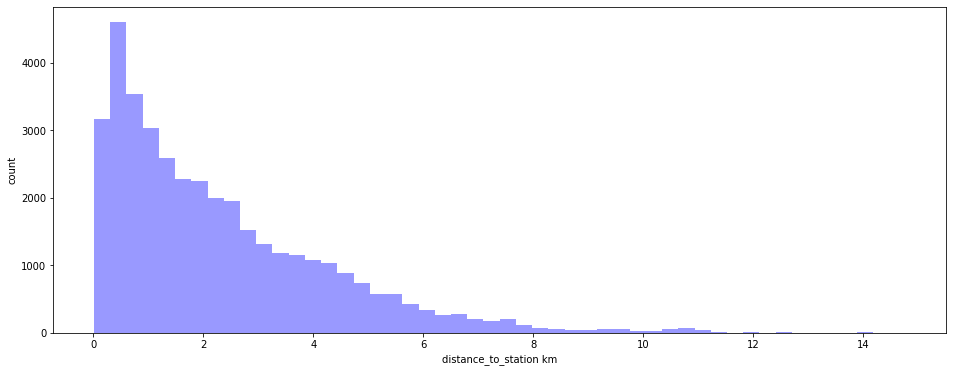

In [17]:
def distance_train_distribution(frame, max_distance):
    """gets the distribution of the distance to the nearest train station,
    max_distance in 'km' is to get a better overview just for assumed valid distances"""
    distance_frame = frame.loc[:, frame.columns[14]]
    distance_frame_sliced = distance_frame[distance_frame < max_distance]
    plt.figure(figsize = (16, 6))
    ax = sns.distplot(distance_frame_sliced, norm_hist = False, kde = False, color = 'blue')
    ax.set(xlabel = 'distance_to_station km', ylabel = count)
    print(frame.shape[0] - distance_frame_sliced.shape[0], ' objects are out of specified range')
    return distance_frame.describe()
    
distance_train_distribution(df, 15)

### Price

The most important attribute of this data set is the target variable "Price". Here it is important to not have any unrealistic value within the data set.

Because the net_price and extra_price is sometimes missing and probably not important to predict the price of a rental object, I decided to analyze only the target variable price.

Most data objects are between 700.- and 3000.- per month, which is within my expectations. There are a few data objects with a monthly price 10'000.- and higher, which I will inspect some of them on ImmoScout24, if these values could be valid. There are also some values near 0, what is impossible. I have to adapt or drop these object in a later stage.

99 objects are above the specified max_price


count      38150.00
mean        1895.22
std        15457.65
min            1.00
25%         1300.00
50%         1600.00
75%         1990.00
max      2850000.00
Name: price, dtype: float64

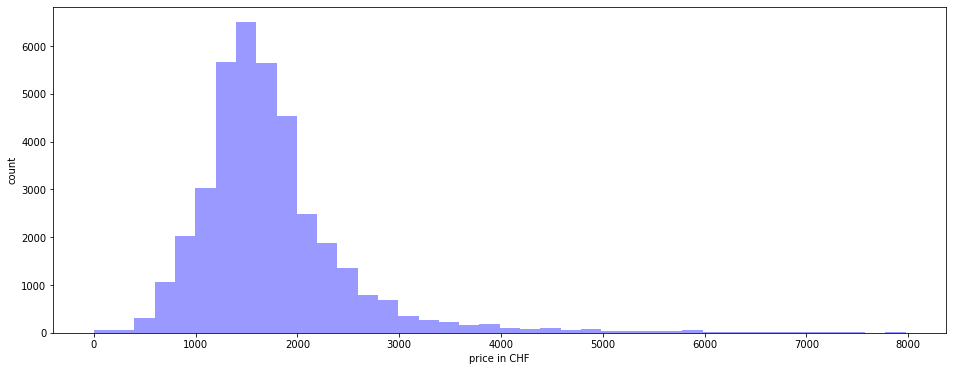

In [18]:
def price_distribution(frame, max_price, bins):
    """gets the distribution of the effective price of the rental objects in CHF"""
    price_frame = pd.to_numeric(frame.loc[:, frame.columns[17]])
    price_frame_sliced = price_frame[price_frame < max_price]
    plt.figure(figsize = (16, 6))
    ax = sns.distplot(price_frame_sliced, bins = bins, norm_hist = False, kde = False, color = 'blue') #change norm_hist to True
    ax.set(xlabel = 'price in CHF', ylabel = count)
    print(frame.shape[0] - price_frame_sliced.shape[0], 'objects are above the specified max_price')
    return np.round(price_frame.describe(), 2)

price_distribution(df, max_price = 8000, bins = 40)

## Correlation Analysis

In this section I analyze correlations between the target variable price and other attributes. This helps to get to a decision, which attributes I can drop which. E.g. I could easly delete an attribute with a lot of missing values if they are not strongly related to the target variable. Hence, I do not need to think about how to fill these values.

Now I have an overview of the missing and some extreme values. I continue with a correlation analyzis of the attributes with a first data cleaning.

Here, I drop the following attributes:
- immoId &rarr; Does not serve any purpose since the data-set is downloaded.
- cityName &rarr; zip_codes serves the purpose of geographic information better because they are unique and each number has its own meaning.
- street &rarr; This is not a very meaningful attribute since there are a lot of streets in different cities with the same name. In addition, there is just not enough data available to cover a majority of the streets in switzerland. I do not want to train a model with such poor representative data.
- netPrice & extraPrice &rarr; I observed some discrepancies in the data set about the extra- and netPrice. Since I do already have my target variable, I can easly drop these two attributes.

Hence, I keep the following attributes in this order:
- objType
- zipCode
- regionId
- canton
- rooms
- floor
- surface
- yearBuilt
- yearRenovated
- lon
- lat
- distanceToStation
- price

In [19]:
def frame_to_numeric(frame):
    """transforms every value of a data frame to numeric if possible"""
    for column in frame.columns:
        try:
            frame.loc[:, column] = pd.to_numeric(frame.loc[:, column])
        except:
            continue #nothing toDo here
    return frame

df_v2 = df.drop(columns = [df.columns[0], df.columns[2], df.columns[6], df.columns[15], df.columns[16]]) #slice the above mentioned attributes
df_v2 = df_v2[df_v2.loc[:, df_v2.columns] != na] #converts all <NA> to NaN
df_v2 = frame_to_numeric(df_v2)

### Enrich Partial Zip-Codes

The swiss zip_codes are categorial variables (unique identifier) with additional geographical information in the first digits. For this reason, I decide to enrich the first two digits of the postal code as an additional categorical variable. In addition, I intend to drop the 4 digit zip_code and transform it to 3 digits, because I want to avoid overfitting. I shouldn't lose too much information about the more expensive regions. On the other hand, the model should be able to cope better with postal codes, which were only present in small numbers in the training set.

In [20]:
def slice_zip_digit(row, digits):
    return int(str(row.loc[df.columns[3]])[:digits]) #returns the first 2 digits of the zip_code

zip_code_2_digits = 'zip_code_2_digits'
zip_code_3_digits = 'zip_code_3_digits'
df_v2[zip_code_2_digits] = df_v2.apply(lambda row: slice_zip_digit(row, 2), axis=1)
df_v2[zip_code_3_digits] = df_v2.apply(lambda row: slice_zip_digit(row, 3), axis=1)

### Analysis

In order to evaluate important attributes, I try to get a couple of them with the help of a correlation analyzis. For this purpose, I eliminate data objects with missing values in hope, to get an appropriate result with the help of more than 2000 remaining rental objects.

If I get values near to 1 or -1 and the correlation is not with the attribute itself (obviously there the correlation is 1), then this feature should be important for the price estimation and I should not drop it.

The features **rooms** and **surface** correlate most by far with the price. Some other attributes like **yearBuilt** and **2_digit_zip_code** should also be taken into consideration combined with the two main features rooms and surface to evaluate further correlations in the data.

In [21]:
df_v2_full_objects = df_v2.dropna()
df_v2_full_objects = frame_to_numeric(df_v2_full_objects)
df_v2_full_objects.corr(method = 'pearson')

C:\Users\Lukas\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,zipCode,regionId,rooms,floor,surface,yearBuilt,yearRenovated,lon,lat,distanceToStation,price,missing_class,zip_code_2_digits,zip_code_3_digits
zipCode,1.000000,0.376657,0.036049,-0.036859,-0.004710,0.006881,0.023908,0.927731,0.358346,0.055957,0.028409,-0.021059,0.999945,0.999999
regionId,0.376657,1.000000,0.010442,-0.106786,-0.014468,-0.023399,-0.013439,0.287061,-0.075667,0.038523,0.014502,-0.008470,0.377979,0.376692
rooms,0.036049,0.010442,1.000000,0.020261,0.755739,0.009374,0.049508,0.033666,0.021837,0.034098,0.493028,-0.045397,0.035520,0.036001
floor,-0.036859,-0.106786,0.020261,1.000000,0.011117,0.011764,-0.088597,-0.017684,0.010840,-0.031547,0.061598,-0.053027,-0.036256,-0.036805
surface,-0.004710,-0.014468,0.755739,0.011117,1.000000,-0.077068,0.098771,-0.009629,-0.036420,0.022833,0.724251,0.057037,-0.005302,-0.004792
yearBuilt,0.006881,-0.023399,0.009374,0.011764,-0.077068,1.000000,0.014231,0.005859,-0.035229,0.006906,-0.114713,-0.055770,0.006638,0.006839
yearRenovated,0.023908,-0.013439,0.049508,-0.088597,0.098771,0.014231,1.000000,0.041171,-0.018276,0.056466,0.106175,0.046298,0.022986,0.023886
lon,0.927731,0.287061,0.033666,-0.017684,-0.009629,0.005859,0.041171,1.000000,0.239002,0.082077,-0.017663,0.000961,0.928003,0.927822
lat,0.358346,-0.075667,0.021837,0.010840,-0.036420,-0.035229,-0.018276,0.239002,1.000000,0.053477,-0.051115,-0.210741,0.357825,0.358249
distanceToStation,0.055957,0.038523,0.034098,-0.031547,0.022833,0.006906,0.056466,0.082077,0.053477,1.000000,-0.098745,0.016013,0.055564,0.055923


Here I can see that the price correlates strongly with the surface and the number of rooms. I create a new variable price per square metres to evaluate additional correlations because it has shown the best correlation.

I think the price per square metres could be a better target variable rather than the price itself since I expect it is easier to predict this feature in my opinion. This would mean to lose 20% of the data, what is acceptable in my opinion.

In addition, I add another attribute last_modified to the frame to analyze, if the yearBuilt, yearRenovated or last_modified correlates with the price.

In [22]:
def add_price_square_metres(row):
    try:
        return row.loc[df.columns[17]] / row.loc[df.columns[9]]
    except:
        return np.nan
    
def add_last_modified(row):
    year_built = row.loc[df.columns[10]]
    year_renovated = row.loc[df.columns[11]]
    last_modified = np.nan
    if not(math.isnan(year_built)):
        last_modified = year_built
    if not(math.isnan(year_renovated)):
        last_modified = year_renovated
    return last_modified

price_square_metres = 'price_square_metres'
last_modified = 'last_modified'
df_v2[price_square_metres] = df_v2.apply(lambda row: add_price_square_metres(row), axis=1)
df_v2[last_modified] = df_v2.apply(lambda row: add_last_modified(row), axis=1)

In [23]:
df_v2_full_objects = df_v2.dropna()
df_v2_full_objects = frame_to_numeric(df_v2_full_objects)
df_v2_full_objects.corr(method = 'pearson')

,zipCode,regionId,rooms,floor,surface,yearBuilt,yearRenovated,lon,lat,distanceToStation,price,missing_class,zip_code_2_digits,zip_code_3_digits,price_square_metres,last_modified
zipCode,1.000000,0.376657,0.036049,-0.036859,-0.004710,0.006881,0.023908,0.927731,0.358346,0.055957,0.028409,-0.021059,0.999945,0.999999,0.046305,0.023908
regionId,0.376657,1.000000,0.010442,-0.106786,-0.014468,-0.023399,-0.013439,0.287061,-0.075667,0.038523,0.014502,-0.008470,0.377979,0.376692,0.031839,-0.013439
rooms,0.036049,0.010442,1.000000,0.020261,0.755739,0.009374,0.049508,0.033666,0.021837,0.034098,0.493028,-0.045397,0.035520,0.036001,-0.464919,0.049508
floor,-0.036859,-0.106786,0.020261,1.000000,0.011117,0.011764,-0.088597,-0.017684,0.010840,-0.031547,0.061598,-0.053027,-0.036256,-0.036805,0.055908,-0.088597
surface,-0.004710,-0.014468,0.755739,0.011117,1.000000,-0.077068,0.098771,-0.009629,-0.036420,0.022833,0.724251,0.057037,-0.005302,-0.004792,-0.410460,0.098771
yearBuilt,0.006881,-0.023399,0.009374,0.011764,-0.077068,1.000000,0.014231,0.005859,-0.035229,0.006906,-0.114713,-0.055770,0.006638,0.006839,-0.031737,0.014231
yearRenovated,0.023908,-0.013439,0.049508,-0.088597,0.098771,0.014231,1.000000,0.041171,-0.018276,0.056466,0.106175,0.046298,0.022986,0.023886,0.042138,1.000000
lon,0.927731,0.287061,0.033666,-0.017684,-0.009629,0.005859,0.041171,1.000000,0.239002,0.082077,-0.017663,0.000961,0.928003,0.927822,0.005268,0.041171
lat,0.358346,-0.075667,0.021837,0.010840,-0.036420,-0.035229,-0.018276,0.239002,1.000000,0.053477,-0.051115,-0.210741,0.357825,0.358249,-0.077766,-0.018276
distanceToStation,0.055957,0.038523,0.034098,-0.031547,0.022833,0.006906,0.056466,0.082077,0.053477,1.000000,-0.098745,0.016013,0.055564,0.055923,-0.134433,0.056466


## Price Comparison

In [24]:
def drop_values(frame, column, amount, asc = False, absolute = False, drop = True):
    """drops or eliminates an amount of data from the frame of the specified column and order,
    possible to not drop (just alter) the values to NaN,
    relative means: 1 is first or last 1% of the whole frame"""
    cut_index = amount
    frame = frame.sort_values(column, ascending = asc).reset_index(drop = True)
    if not(absolute):
        cut_index = int((amount / 100) * frame.shape[0])
    if drop:
        frame = frame.loc[cut_index:,]
    else:
        frame.loc[:cut_index-1, column] = np.nan
    return frame

def drop_outlier_objects(frame):
    """drops a relative amount of data from all specified columns in the data-set at top and or bottom level"""
    frame = drop_values(frame, df.columns[7], amount = 1, absolute = True, drop = False) #drop 2 rooms with impossible high values
    frame = drop_values(frame, df.columns[8], amount = 0.15, asc = True, drop = False) #drop all -2 floors and lower rooms (seems wrong)
    frame = drop_values(frame, df.columns[8], amount = 2, absolute = True, drop = False) #drop 2 top floors (impossible values)
    frame = drop_values(frame, df.columns[9], amount = 4, absolute = True) #drop 4 objects with obviously too high surface values
    frame = drop_values(frame, df.columns[9], amount = 16, asc = True, absolute = True) #drop bottom 16 obviously too low surface
    frame = drop_values(frame, df.columns[14], amount = 2, absolute = True, drop = True) #drop 2 geographical wrong objects
    frame = drop_values(frame, df.columns[17], amount = 6, absolute = True, drop = True) #drop 6 obviously too high priced objects
    frame = drop_values(frame, df.columns[17], amount = 50, asc = True, absolute = True, drop = True) #obv too low
    frame = drop_values(frame, price_square_metres, amount = 50, asc = True, absolute = True, drop = True) #cautious dropping
    frame = drop_values(frame, price_square_metres, amount = 50, absolute = True, drop = True)
    frame = frame[frame.loc[:, df.columns[7]] != 3.4]
    return frame

df_v3 = drop_outlier_objects(df_v2)

### Price & Object-Type

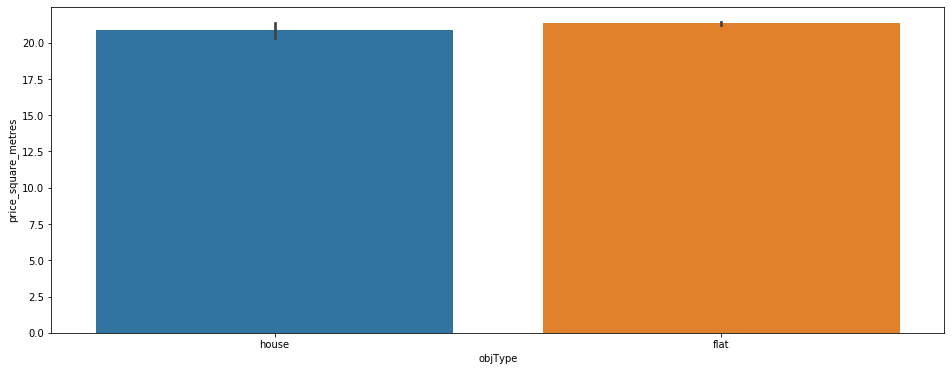

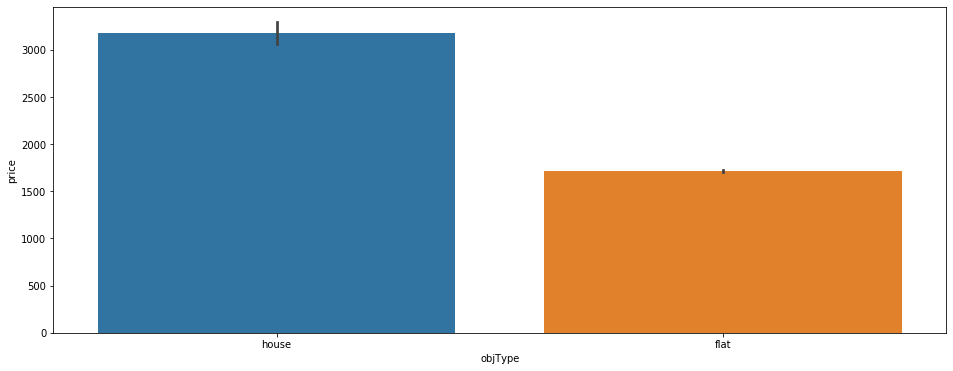

In [25]:
price_square_object_frame = df_v3.loc[:, [price_square_metres, df.columns[1]]].dropna()
price_object_frame = df_v3.loc[:, [df.columns[17], df.columns[1]]].dropna()

plt.figure(figsize = (16, 6))
sns.barplot(x = df.columns[1], y = price_square_metres, data = price_square_object_frame)
plt.figure(figsize = (16, 6))
sns.barplot(x = df.columns[1], y = df.columns[17], data = price_object_frame)

### Price & Surface

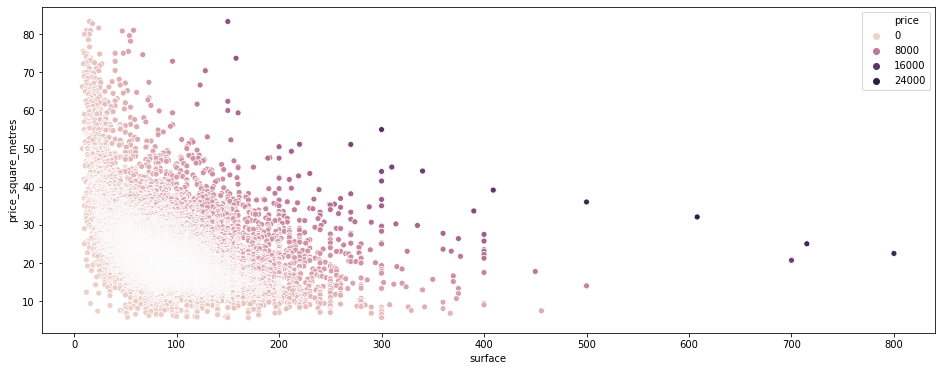

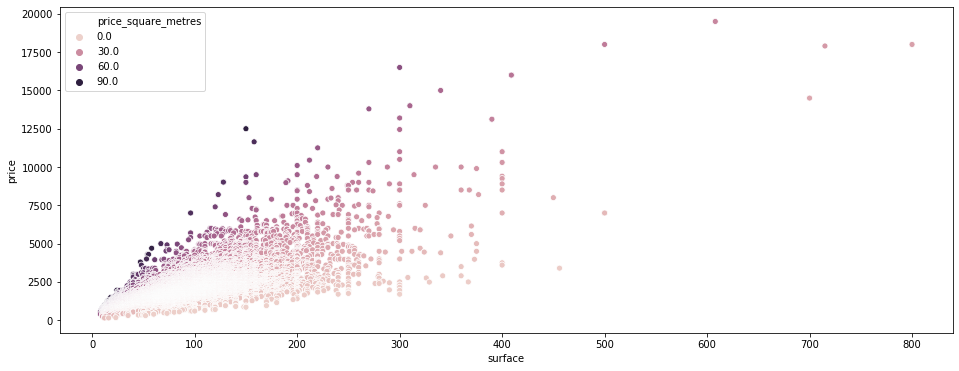

In [26]:
price_surface_frame = df_v3.loc[:, [df.columns[17], price_square_metres, df.columns[9]]].dropna()

plt.figure(figsize = (16, 6))
ax = sns.scatterplot(x = df.columns[9], y = price_square_metres, data = price_surface_frame, hue = df.columns[17])
plt.figure(figsize = (16, 6))
ax = sns.scatterplot(x = df.columns[9], y = df.columns[17], data = price_surface_frame, hue = price_square_metres)

### Price & Rooms

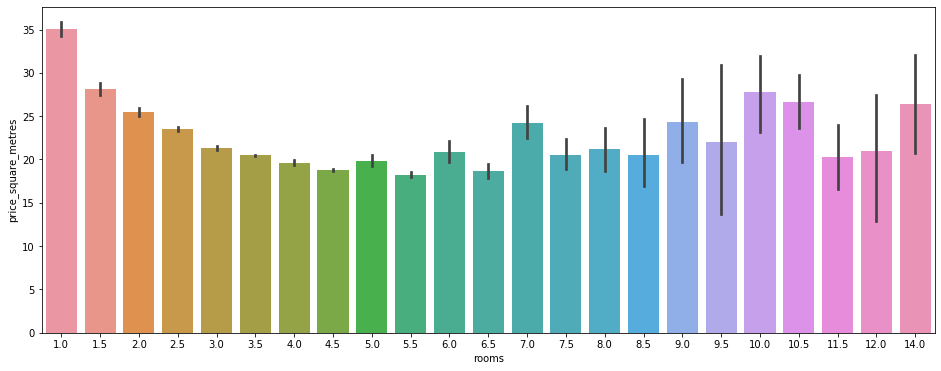

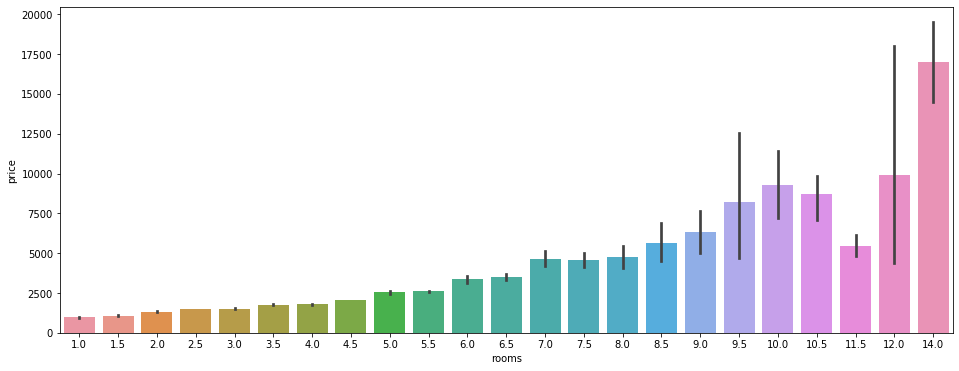

In [27]:
price_rooms_frame = df_v3.loc[:, [df.columns[17], price_square_metres, df.columns[7]]].dropna()

plt.figure(figsize = (16, 6))
sns.barplot(x = df.columns[7], y = price_square_metres, data = price_rooms_frame)
plt.figure(figsize = (16, 6))
sns.barplot(x = df.columns[7], y = df.columns[17], data = price_rooms_frame)

### Price vs. Renovation and Built-Year

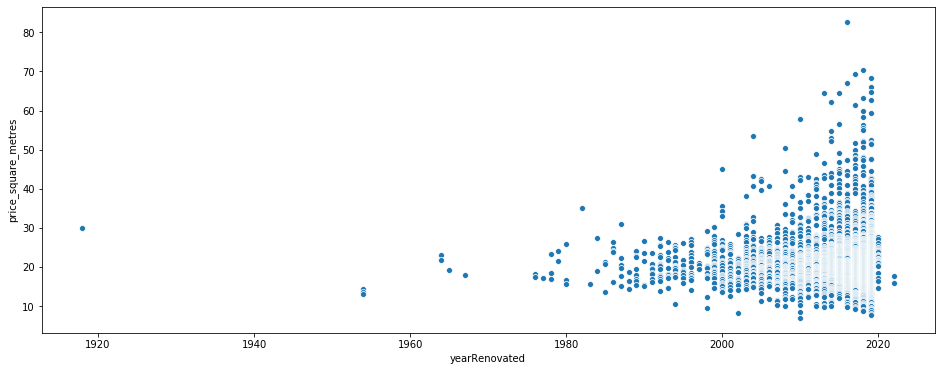

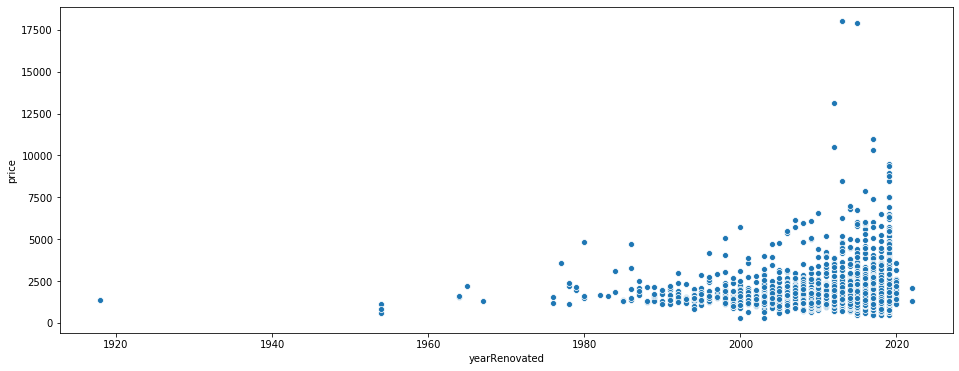

In [28]:
price_year_built_frame = df_v3.loc[:, [df.columns[17], price_square_metres, df.columns[11], zip_code_2_digits, df.columns[5]]].dropna()
price_year_built_frame = frame_to_numeric(price_year_built_frame)
price_year_built_frame = price_year_built_frame[price_year_built_frame[df.columns[11]] > 1900]
plt.figure(figsize = (16, 6))
ax = sns.scatterplot(x = df.columns[11], y = price_square_metres, data = price_year_built_frame)
plt.figure(figsize = (16, 6))
ax = sns.scatterplot(x = df.columns[11], y = df.columns[17], data = price_year_built_frame)

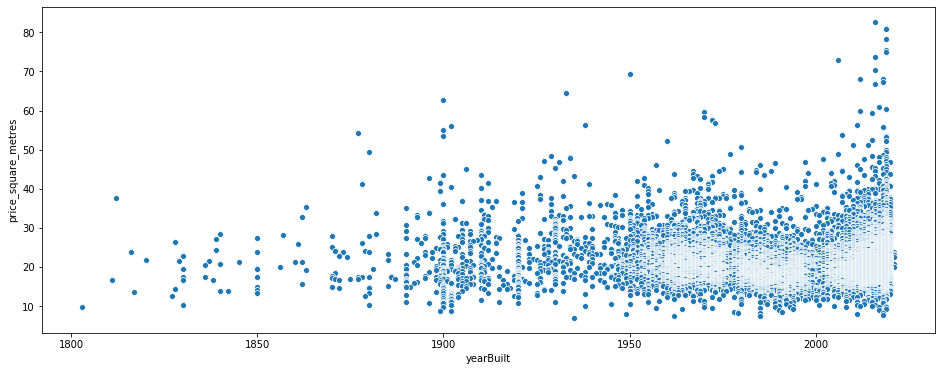

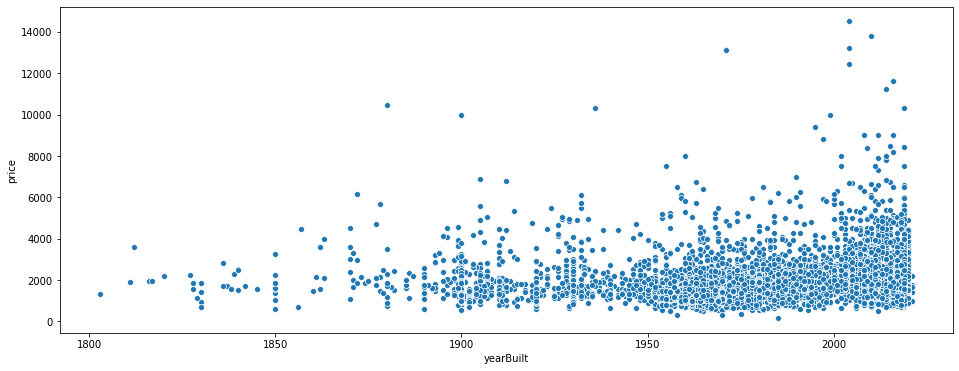

In [29]:
price_year_renovated_frame = df_v3.loc[:, [df.columns[17], price_square_metres, df.columns[10], zip_code_2_digits, df.columns[5]]].dropna()
price_year_renovated_frame = price_year_renovated_frame[price_year_renovated_frame[df.columns[10]] > 1800]
plt.figure(figsize = (16, 6))
ax = sns.scatterplot(x = df.columns[10], y = price_square_metres, data = price_year_renovated_frame)
plt.figure(figsize = (16, 6))
ax = sns.scatterplot(x = df.columns[10], y = df.columns[17], data = price_year_renovated_frame)

### Price & Canton

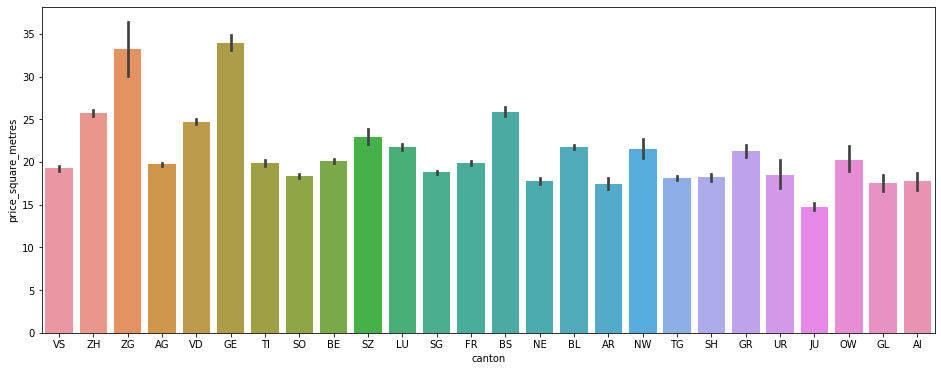

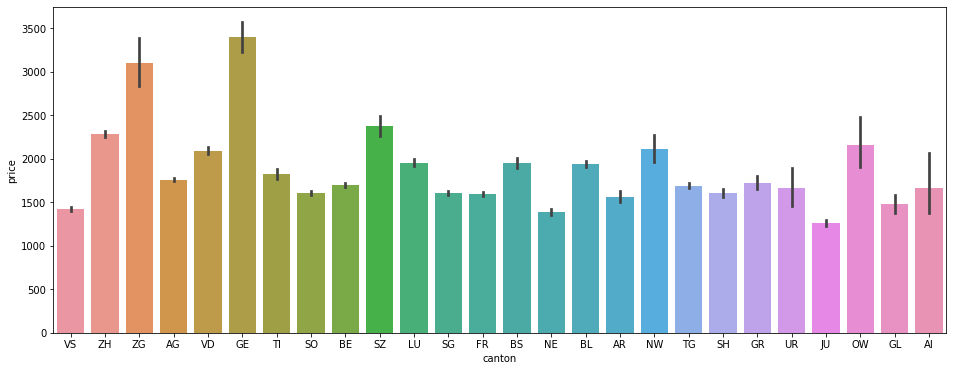

In [30]:
price_canton_frame = df_v3.loc[:, [df.columns[17], price_square_metres, df.columns[5]]].dropna()

plt.figure(figsize = (16, 6))
sns.barplot(x = df.columns[5], y = price_square_metres, data = price_canton_frame)
plt.figure(figsize = (16, 6))
sns.barplot(x = df.columns[5], y = df.columns[17], data = price_canton_frame)

Price & 2 Digit Postal Code

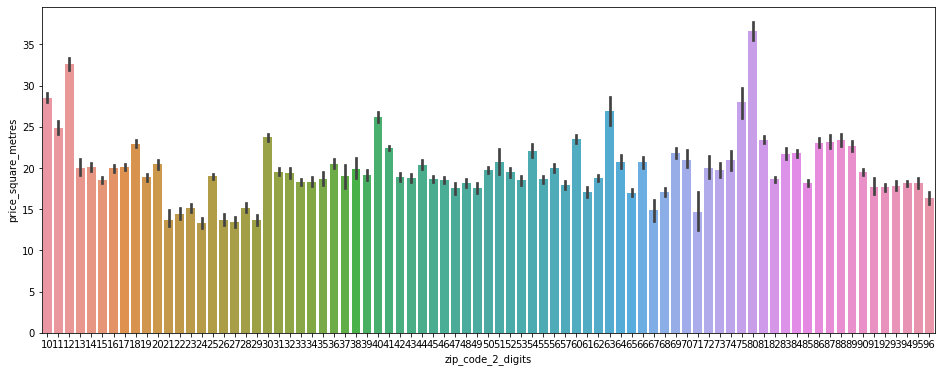

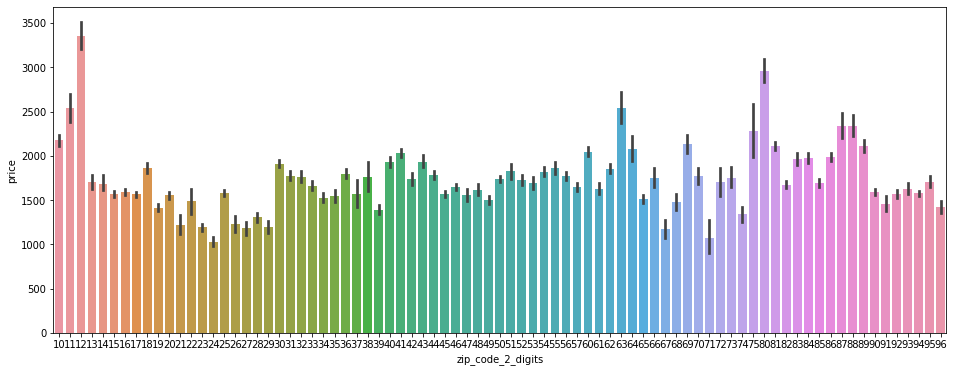

In [31]:
price_2zip_frame = df_v3.loc[:, [df.columns[17], price_square_metres, zip_code_2_digits]].dropna()

plt.figure(figsize = (16, 6))
sns.barplot(x = zip_code_2_digits, y = price_square_metres, data = price_2zip_frame)
plt.figure(figsize = (16, 6))
sns.barplot(x = zip_code_2_digits, y = df.columns[17], data = price_2zip_frame)

### Price & Floor

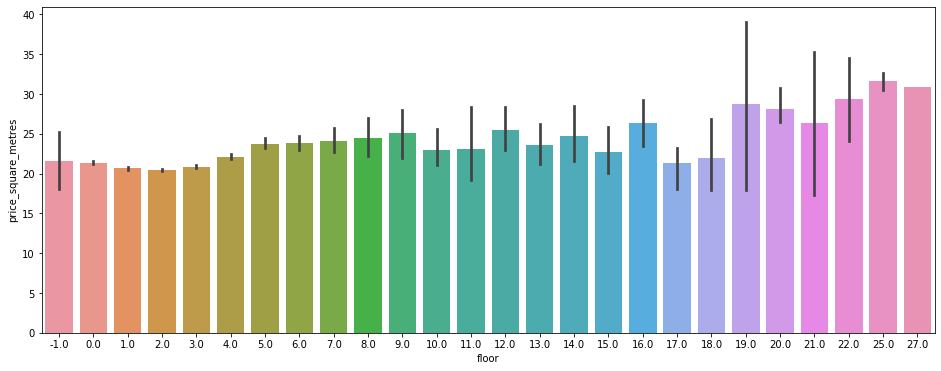

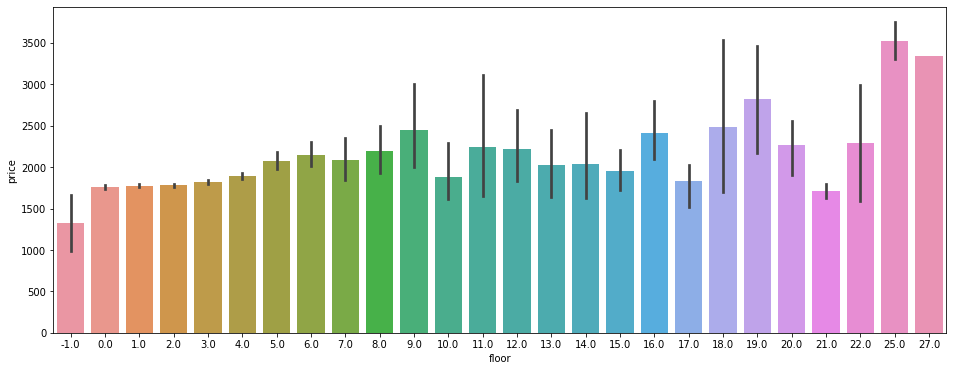

In [32]:
price_floor_frame = df_v3.loc[:, [df.columns[17], price_square_metres, df.columns[8]]].dropna()

plt.figure(figsize = (16, 6))
sns.barplot(x = df.columns[8], y = price_square_metres, data = price_floor_frame)
plt.figure(figsize = (16, 6))
sns.barplot(x = df.columns[8], y = df.columns[17], data = price_floor_frame)

### Price & RegionID

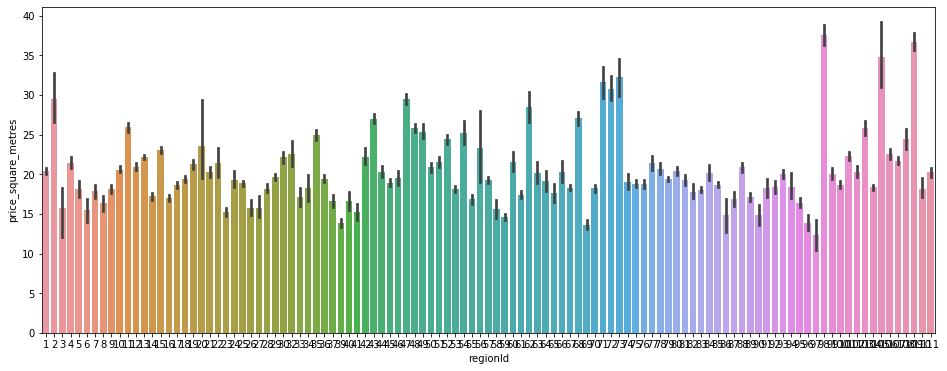

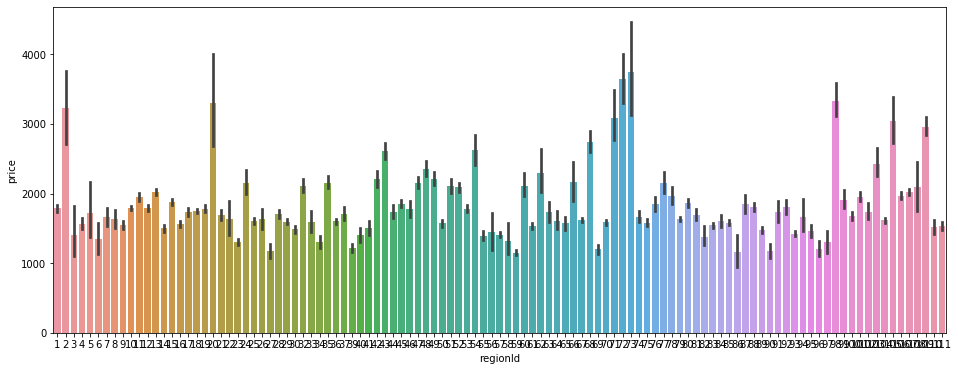

In [33]:
price_floor_frame = df_v3.loc[:, [df.columns[17], price_square_metres, df.columns[4]]].dropna()

plt.figure(figsize = (16, 6))
sns.barplot(x = df.columns[4], y = price_square_metres, data = price_floor_frame)
plt.figure(figsize = (16, 6))
sns.barplot(x = df.columns[4], y = df.columns[17], data = price_floor_frame)

### Price & Trainstation Distance

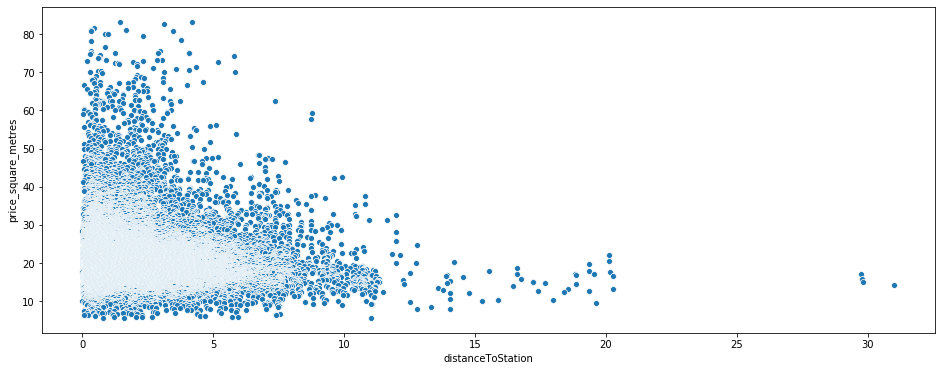

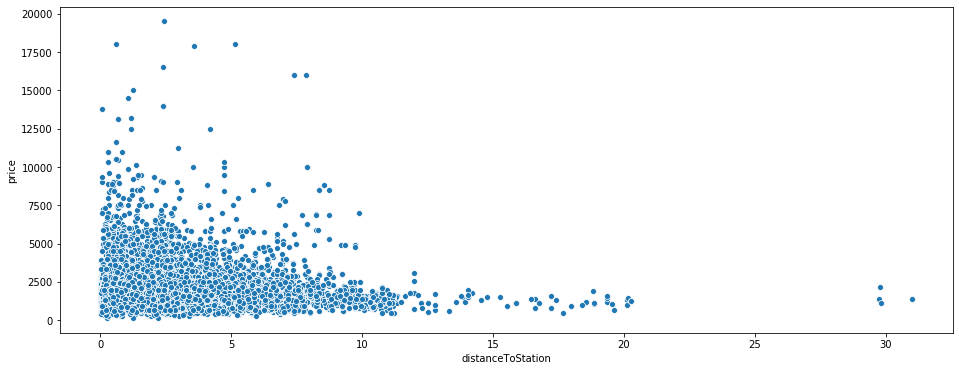

In [34]:
price_distance_frame = df_v3.loc[:, [df.columns[17], price_square_metres, df.columns[14]]].dropna()
plt.figure(figsize = (16, 6))
ax = sns.scatterplot(x = df.columns[14], y = price_square_metres, data = price_distance_frame)
plt.figure(figsize = (16, 6))
ax = sns.scatterplot(x = df.columns[14], y = df.columns[17], data = price_distance_frame)

## Data Frame cleaning

For modelling purpose I drop the following attributes:
- zipCode &rarr; 2 and 3 digit zip codes and canton contains enough geographical information. I also want to prevent the model overfitting. I will lose some zip codes after cleaning completely because most of my postal codes contain less than 5 data objects.
- regionId &rarr; As the analysis has shown, 2- and 3-digit postal codes and canton provides enough geographic information
- floor &rarr; The analysis has shown that the floor is nor very relevant in order to predict the offer price
- lon & lat &rarr; they were originally fetched to calculate the distance between an object and the nearest train station, which is according to the price analysis a very important feature.
- last_modified &rarr; I intend not to use the year of the last modification, because this would indicate to train the network with values that are not true, because I have a lot of year_building before 1900 and they are never renovated, which is not true. But I do not want to lose information about the year_built or year_renovated since they are very important since they are newly built or renovated.

In [35]:
df_v4 = df_v3.drop(columns = [df.columns[3], df.columns[4], df.columns[8], df.columns[12], df.columns[13], miss, last_modified])

objects with no missing values:  2318.0 



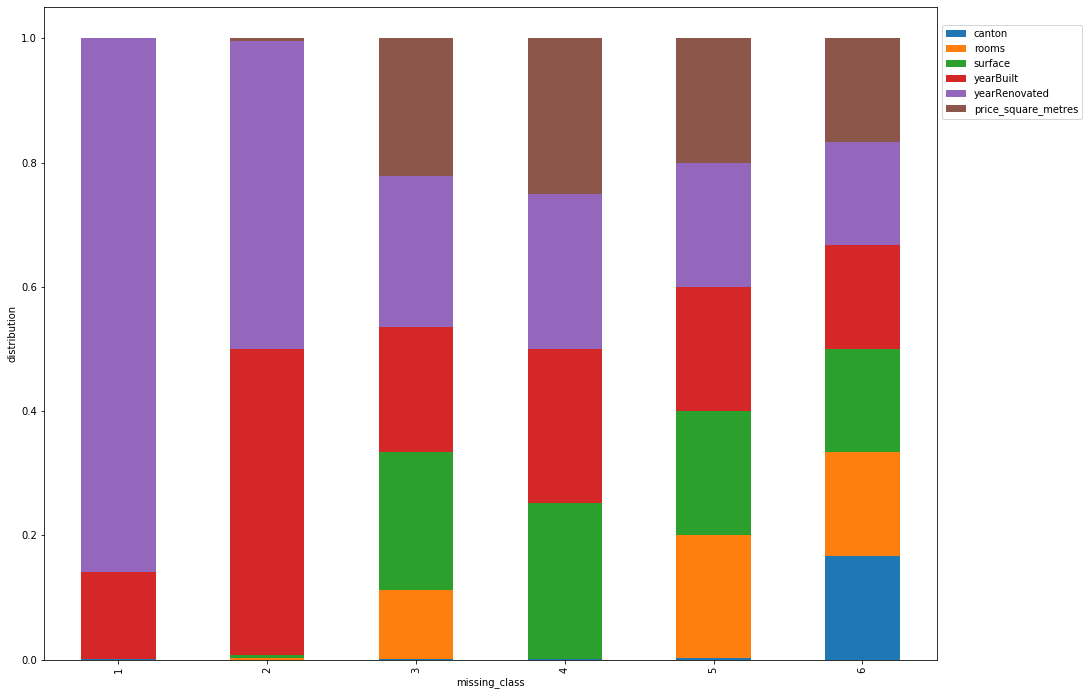

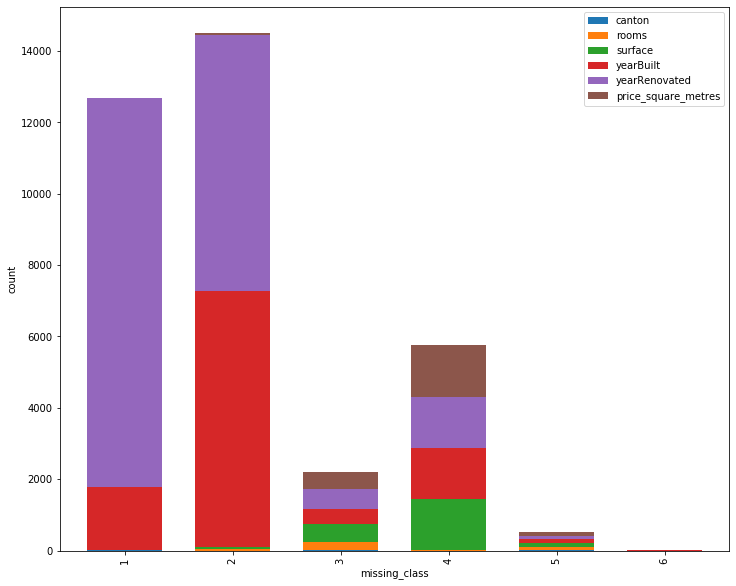

In [36]:
df_v4_missing = create_missing_values_set(df_v4, missing = np.nan)
missing_distribution_100(df_v4_missing)
missing_distribution(df_v4_missing, df_v4.shape[0])

## Complete Missing Values (where appropriate)

## Neural Network Data Preparation